In [1]:
%matplotlib inline

In [2]:
import os

import geopandas

import pandas as pd

import wget


def load_best_track(code='al14', year='2018'):
    fname = f'{code}{year}_best_track.zip'
    url = f'https://www.nhc.noaa.gov/gis/best_track/{fname}'

    if not os.path.isfile(fname):
        import wget
        fname = wget.download(url)

    os.environ['CPL_ZIP_ENCODING'] = 'UTF-8'

    radii = geopandas.read_file(
        f'/{code.upper()}{year}_radii.shp',
        vfs='zip://{}'.format(fname)
    )

    pts = geopandas.read_file(
        f'/{code.upper()}{year}_pts.shp',
        vfs='zip://{}'.format(fname)
    )
    radii.index = pd.to_datetime(radii['SYNOPTIME'], format='%Y%m%d%H', errors='coerce').values
    return radii, pts

radii, pts = load_best_track(code='al14', year='2018')

bbox = radii['geometry'].total_bounds

In [3]:
from erddapy import ERDDAP


e = ERDDAP(server='https://data.ioos.us/gliders/erddap')

In [4]:
min_lon, max_lon = bbox[0], bbox[2]
min_lat, max_lat = bbox[1], bbox[3]
        
kw = {
    'standard_name': 'sea_water_temperature',
    'min_lon': min_lon,
    'max_lon': max_lon,
    'min_lat': min_lat,
    'max_lat': max_lat,
    'min_time': '2018-10-07T00:00:00Z',
    'max_time': '2018-07-16T00:00:00Z',
    'cdm_data_type': 'trajectoryprofile'
}

In [5]:
import pandas as pd


search_url = e.get_search_url(response='csv', **kw)

search = pd.read_csv(search_url)
gliders = search['Dataset ID'].values
print('Found {} Glider Datasets:\n{}'.format(len(gliders), '\n'.join(gliders)))

Found 25 Glider Datasets:
allrutgersGliders
allsecooraGliders
bass-20180808T0000
ng228-20180801T0000
ng230-20180801T0000
ng257-20180801T0000
ng258-20180801T0000
ng261-20180801T0000
ng279-20180801T0000
ng288-20180801T0000
ng290-20180701T0000
ng295-20180701T0000
ng296-20180701T0000
ng342-20180701T0000
ng429-20180701T0000
ng448-20180701T0000
pelagia-20180910T0000
ramses-20180704T0000
ramses-20180907T0000
ru33-20180801T1323
sam-20180824T0000
sp010-20180620T1455
sp022-20180912T1553
sp066-20180629T1411
sylvia-20180802T0930


In [6]:
server = 'https://data.ioos.us/gliders/erddap'

dataset_id = 'ng288-20180801T0000'

variables = [
 'depth',
 'latitude',
 'longitude',
 'salinity',
 'temperature',
 'time',
]

In [7]:
from erddapy import ERDDAP


e = ERDDAP(
    server=server,
    protocol='tabledap',
)

e.dataset_id = dataset_id
e.variables = variables
        
print(
    e.get_download_url(
        response='mat',
    )
)

https://data.ioos.us/gliders/erddap/tabledap/ng288-20180801T0000.mat?depth,latitude,longitude,salinity,temperature,time


In [8]:
df = e.to_pandas(
    index_col='time',
    parse_dates=True,
    skiprows=(1,)
).dropna()

df.head()

,depth,latitude,longitude,salinity,temperature
time,,,,,
2018-08-21 03:44:15,0.992094,27.339478,-85.563141,35.689182,30.417562
2018-08-21 03:44:15,1.061540,27.339478,-85.563141,35.689510,30.416750
2018-08-21 03:44:15,1.140908,27.339478,-85.563141,35.689960,30.417750
2018-08-21 03:44:15,1.230196,27.339478,-85.563141,35.690530,30.417400
2018-08-21 03:44:15,1.299642,27.339478,-85.563141,35.691254,30.417627


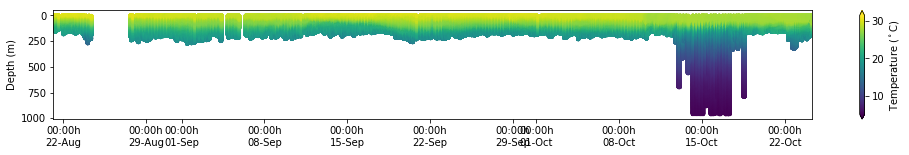

In [9]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(17, 2))
cs = ax.scatter(df.index, df['depth'], s=15, c=df['temperature'],
                marker='o', edgecolor='none')

ax.invert_yaxis()
ax.set_xlim(df.index[0], df.index[-1])
xfmt = mdates.DateFormatter('%H:%Mh\n%d-%b')
ax.xaxis.set_major_formatter(xfmt)

cbar = fig.colorbar(cs, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Temperature ($^\circ$C)')
ax.set_ylabel('Depth (m)');

In [10]:
import cartopy.crs as ccrs


def make_map():
    fig, ax = plt.subplots(
        subplot_kw={'projection': ccrs.PlateCarree()},
        figsize=(9, 9)
    )
    ax.stock_img()
    ax.gridlines(draw_labels=True)
    ax.coastlines('10m')
    return fig, ax

In [11]:
import shapely


dive = df.loc[df['depth'] > 900]
hurr = df.loc[(df.index >= radii.index[0]) & (df.index <= radii.index[-1])]

coords = zip(df['longitude'], df['latitude'])
track = shapely.geometry.LineString(coords)

intersects = radii.loc[radii['geometry'].intersects(track)]

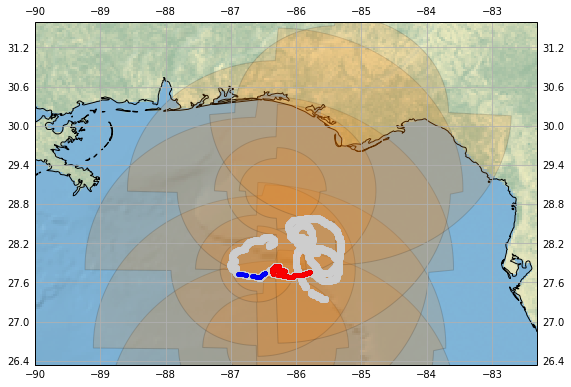

In [12]:
fig, ax = make_map()

ax.plot(df['longitude'], df['latitude'], color='lightgray', marker='o', alpha=0.15)
ax.plot(dive['longitude'], dive['latitude'], color='blue', marker='.', alpha=0.15)
ax.plot(hurr['longitude'], hurr['latitude'], color='red', marker='.', alpha=0.15)

ax.set_extent([df['longitude'].min()-3, df['longitude'].max()+3,
               df['latitude'].min()-1, df['latitude'].max()+3]);

ax.add_geometries(intersects['geometry'].tolist(), ccrs.PlateCarree(),
    facecolor='#FF7E00', alpha=0.15, edgecolor='black');